In [563]:
import pandas as pd
import math
import numpy as np
from functools import partial
import dateutil.parser
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from src.analysis.task_energy import calc_energies_on_dataframe, calc_job_energy_on_job_row, calc_job_energy_on_job_row_single

In [564]:
def test_calc_job_energy(count_encode, count_decode, encode_power, encode_time, decode_power, decode_time):
    start_encode = encode_time[0]
    end_encode = encode_time[-1]

    start_decode = str(decode_time[0])
    end_decode = str(decode_time[-1])
    start_decode = dateutil.parser.parse(start_decode)
    end_decode = dateutil.parser.parse(end_decode)


    df = pd.DataFrame(
        data={
              'start_time_encode': [start_encode], 'end_time_encode': [end_encode], 'count_encode': [count_encode],
              # 'target_encode': [{'start_time': start_encode, 'end_time': end_encode}],
              'start_time_decode': [start_decode], 'end_time_decode': [end_decode], 'count_decode': [count_decode]
              # 'target_decode': [{'start_time': start_decode, 'end_time': end_decode}]
              },
        dtype=object
    )

    dti_e = pd.to_datetime(encode_time)
    power_encode_list = encode_power
    df_power_e = pd.Series(data=power_encode_list, name='power', index=dti_e)
    # print(df_power_e)
    _calc_job_energy_encode = partial(calc_job_energy_on_job_row, df_power_e,
                                      lambda x: x[f'start_time_encode'],
                                      lambda x: x[f'end_time_encode'],
                                      lambda x: x[f'count_encode'])
    df['target_encode_energy'] = df.apply(_calc_job_energy_encode, axis=1)

    dti_d = pd.to_datetime(decode_time)
    power_decode_list = decode_power
    df_power_d = pd.Series(data=power_decode_list, name='power', index=dti_d)
    # print(df_power_d)
    _calc_job_energy_target_decode = partial(calc_job_energy_on_job_row, df_power_d,
                                             lambda x: x[f'start_time_decode'],
                                             lambda x: x[f'end_time_decode'],
                                             lambda x: x[f'count_decode'])
    df['decode_energy'] = df.apply(_calc_job_energy_target_decode, axis=1)

    # # calc energy as new column
    df['energy'] = df[['target_encode_energy', 'decode_energy']].sum(axis=1)

    return df

In [565]:
def get_nearest_power(data, start_time, end_time):
    # index = data.index.get_loc(timestamp,"nearest") #old version
    index_start = data.index.get_indexer([start_time], method='nearest')[0] #new version
    index_end = data.index.get_indexer([end_time], method='nearest')[0]

    # index_start = index_start + 1
    # index_end = index_end + 1
    power_log = data.reset_index()
    power_select = power_log.loc[index_start:index_end, ['time_stamp', 'power']]#one到two行，ac列
    time_list = power_select['time_stamp'].tolist()
    power_list = power_select['power'].tolist()

    return power_list, time_list

In [566]:
power_log = pd.read_csv("../metrics/energy_log/power_log_2023-04-13.csv", names=['time_stamp', 'power'])
power_log['time_stamp'] = pd.to_datetime(power_log['time_stamp'])
power_log.head()

,time_stamp,power
0,2023-04-13 10:49:21.599,77.669
1,2023-04-13 10:49:22.443,78.338
2,2023-04-13 10:49:22.925,77.955
3,2023-04-13 10:49:23.415,78.434
4,2023-04-13 10:49:23.897,78.315


In [567]:
codec = 'SVT-AV1'
power_log = pd.read_csv("../metrics/energy_log/power_log_2023-04-13.csv", names=['time_stamp', 'power'])
power_log['time_stamp'] = pd.to_datetime(power_log['time_stamp'])# Converting data types to date types
power_log = power_log.set_index('time_stamp')# Set date to index
power_log.head()

,power
time_stamp,
2023-04-13 10:49:21.599,77.669
2023-04-13 10:49:22.443,78.338
2023-04-13 10:49:22.925,77.955
2023-04-13 10:49:23.415,78.434
2023-04-13 10:49:23.897,78.315


In [568]:
df_metrics = pd.read_csv(f'../metrics/energy_log/YOUTUBE_UGC_1080P_{codec}_metrics_timestamp_repeat.csv')
df_metrics.head(8)

,vid,category,resolution,width,height,pixfmt,framrate,bitrate_rawvideo (kb/s),bitrate_encoded (kb/s),PSNR,VMAF,QP,start_time_encode,end_time_encode,start_time_decode,end_time_decode
0,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,27486,45.994384,97.962394,12,2023-04-18 17:39:13.492594,2023-04-18 17:40:50.030741,2023-04-18 17:40:56.011358,2023-04-18 17:41:01.844901
1,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,18323,44.159637,97.710907,18,2023-04-18 17:41:13.810804,2023-04-18 17:42:50.691332,2023-04-18 17:42:55.703967,2023-04-18 17:43:00.883091
2,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,12981,42.780976,97.438095,24,2023-04-18 17:43:12.845153,2023-04-18 17:44:42.852141,2023-04-18 17:44:47.470108,2023-04-18 17:44:52.109920
3,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,7822,40.996289,96.824846,30,2023-04-18 17:45:04.048405,2023-04-18 17:46:28.898708,2023-04-18 17:46:32.576190,2023-04-18 17:46:36.389364
4,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,4491,39.222075,95.337259,36,2023-04-18 17:46:48.326102,2023-04-18 17:48:07.922314,2023-04-18 17:48:11.125796,2023-04-18 17:48:14.279319
5,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,2759,37.663094,93.100422,42,2023-04-18 17:48:26.227214,2023-04-18 17:49:41.560123,2023-04-18 17:49:44.267084,2023-04-18 17:49:46.901745
6,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,1795,36.159910,90.428001,48,2023-04-18 17:49:58.880641,2023-04-18 17:51:09.615694,2023-04-18 17:51:12.048142,2023-04-18 17:51:14.378015
7,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.0,622090,1207,34.569354,86.740596,54,2023-04-18 17:51:26.367129,2023-04-18 17:52:33.476804,2023-04-18 17:52:35.600528,2023-04-18 17:52:37.654316


In [569]:
df_metrics = df_metrics.rename(columns={'energy': 'total_energy'})
df_metrics['start_time_encode'] = pd.to_datetime(df_metrics['start_time_encode'])
df_metrics['end_time_encode'] = pd.to_datetime(df_metrics['end_time_encode'])
df_metrics['start_time_decode'] = pd.to_datetime(df_metrics['start_time_decode'])
df_metrics['end_time_decode'] = pd.to_datetime(df_metrics['end_time_decode'])
df_metrics['start_time_encode'].head(8)

0   2023-04-18 17:39:13.492594
1   2023-04-18 17:41:13.810804
2   2023-04-18 17:43:12.845153
3   2023-04-18 17:45:04.048405
4   2023-04-18 17:46:48.326102
5   2023-04-18 17:48:26.227214
6   2023-04-18 17:49:58.880641
7   2023-04-18 17:51:26.367129
Name: start_time_encode, dtype: datetime64[ns]

In [570]:
count_repeat_list = []
count_encode_list = []
count_decode_list = []

encode_energy_list = []
decode_energy_list = []
energy_list = []

nearest_s_e = []
nearest_e_e = []
nearest_s_d = []
nearest_e_d = []

In [571]:
def power_filter(power_list, time_list):
    # print(power_list)
    group_size = math.ceil(len(power_list)/10)

    # # # get rid of the unusual power number
    # count = 10
    # power_list_filter = []
    # time_list_filter = []
    #
    # for i in range(len(power_list)):
    #     if power_list[i] > 90:
    #         power_list_filter.append(power_list[i])
    #         time_list_filter.append(time_list[i])


    # get rid of the repeat encoding process
    count = 0
    power_list_filter = []
    time_list_filter = []
    for i in range(0,len(power_list),group_size):
        count +=1

        power_list_of_groups = power_list[i:i+group_size]
        time_list_of_groups = time_list[i:i+group_size]

        print(power_list_of_groups)
        print(all(_ >= 90 for _ in power_list_of_groups))  # True

        power_list_filter += power_list_of_groups
        time_list_filter += time_list_of_groups
        if all(_ >= 90 for _ in power_list_of_groups):
            power_list_filter += power_list_of_groups
            time_list_filter += time_list_of_groups
        else:
            count -= 1

    # print(count)
    # print(power_list)
    # print(len(power_list))
    # print(power_list_filter)
    # print(len(power_list_filter))
    return count, power_list_filter, time_list_filter

In [572]:
count_repeat = 10
for i in range(len(df_metrics)):
    print(df_metrics['vid'][i])
    print(f"QP level: {df_metrics['QP'][i]}")

    s_e = df_metrics['start_time_encode'][i]
    e_e = df_metrics['end_time_encode'][i]
    encode_power, encode_time = get_nearest_power(power_log, s_e, e_e)
    count_encode, encode_power_filter, encode_time_filter = power_filter(encode_power, encode_time)

    s_d = df_metrics['start_time_decode'][i]
    e_d = df_metrics['end_time_decode'][i]
    decode_power, decode_time = get_nearest_power(power_log, s_d, e_d)
    count_decode = 1
    count_decode, decode_power_filter, decode_time_filter = power_filter(decode_power, decode_time)

    df_energy = test_calc_job_energy(count_encode, count_decode, encode_power_filter, encode_time_filter, decode_power, decode_time)
    # print(df_energy.T)
    print('------------------------------------------------------')

    count_repeat_list.append(count_repeat)
    count_encode_list.append(count_encode)
    count_decode_list.append(count_decode)

    encode_energy_list.append(df_energy['target_encode_energy'][0])
    decode_energy_list.append(df_energy['decode_energy'][0])
    energy_list.append(df_energy['energy'][0])

    nearest_s_e.append(df_energy['start_time_encode'][0])
    nearest_e_e.append(df_energy['end_time_encode'][0])
    nearest_s_d.append(df_energy['start_time_decode'][0])
    nearest_e_d.append(df_energy['end_time_decode'][0])

    # nearest_s_e.append(df_energy['target_encode'][0]['start_time'])
    # nearest_e_e.append(df_energy['target_encode'][0]['end_time'])
    # nearest_s_d.append(df_energy['target_decode'][0]['start_time'])
    # nearest_e_d.append(df_energy['target_decode'][0]['end_time'])

Animation_1080P-05f8
QP level: 12
[85.628, 89.626, 133.21, 253.98, 208.42, 110.8, 179.96, 167.97, 177.77, 200.67, 183.37, 213.41, 204.66, 212.52, 131.08, 188.36, 102.13, 106.7]
False
[244.47, 252.77, 111.89, 124.57, 131.17, 227.67, 117.31, 202.1, 158.92, 198.18, 202.22, 207.5, 183.62, 209.57, 204.77, 208.2, 125.54, 184.56]
True
[96.337, 104.82, 215.95, 253.51, 135.94, 117.28, 132.45, 209.77, 151.54, 190.25, 156.8, 203.29, 199.93, 210.69, 186.46, 208.63, 146.9, 146.5]
True
[99.728, 150.08, 253.72, 192.48, 117.45, 115.15, 191.59, 161.54, 148.31, 205.81, 203.87, 192.06, 205.97, 206.86, 211.55, 187.93, 103.4, 227.77]
True
[253.85, 119.29, 122.35, 140.8, 214.37, 153.96, 155.89, 202.32, 203.33, 192.26, 208.06, 207.83, 164.61, 115.88, 175.52, 254.67, 167.42, 115.73]
True
[108.06, 170.82, 166.65, 176.37, 197.16, 201.55, 191.99, 201.44, 208.55, 192.1, 98.238, 102.27, 215.56, 253.72, 129.15, 132.41, 146.18, 179.51]
True
[149.22, 203.69, 202.15, 182.63, 208.25, 181.38, 143.5, 151.46, 101.82, 206.

In [573]:
df_metrics['count_repeat'] = count_repeat_list
# nearest time
df_metrics['nearest_start_time_encode'] = nearest_s_e
df_metrics['nearest_end_time_encode'] = nearest_e_e
df_metrics['nearest_start_time_decode'] = nearest_s_d
df_metrics['nearest_end_time_decode'] = nearest_e_d

df_metrics['target_encode_energy'] = encode_energy_list
df_metrics['count_encode'] = count_encode_list

df_metrics['decode_energy'] = decode_energy_list
df_metrics['count_decode'] = count_decode_list

df_metrics['total_energy'] = energy_list

metrics_name = f'../metrics/energy/YOUTUBE_UGC_1080P_{codec}_metrics_energy_repeat_filter.csv'
df_metrics.to_csv(metrics_name, index=None)
df_metrics

,vid,category,resolution,width,height,pixfmt,framrate,bitrate_rawvideo (kb/s),bitrate_encoded (kb/s),PSNR,...,count_repeat,nearest_start_time_encode,nearest_end_time_encode,nearest_start_time_decode,nearest_end_time_decode,target_encode_energy,count_encode,decode_energy,count_decode,total_energy
0,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,27486,45.994384,...,10,2023-04-18 17:39:13.723,2023-04-18 17:40:50.010,2023-04-18 17:40:55.772,2023-04-18 17:41:02.015,1876.455536,9,94.058341,7,1970.513878
1,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,18323,44.159637,...,10,2023-04-18 17:41:13.537,2023-04-18 17:42:50.709,2023-04-18 17:42:55.500,2023-04-18 17:43:00.638,2105.410618,8,53.726924,10,2159.137543
2,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,12981,42.780976,...,10,2023-04-18 17:43:12.630,2023-04-18 17:44:42.985,2023-04-18 17:44:47.307,2023-04-18 17:44:52.113,1599.826117,10,83.013958,6,1682.840075
3,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,7822,40.996289,...,10,2023-04-18 17:45:04.129,2023-04-18 17:46:28.790,2023-04-18 17:46:32.637,2023-04-18 17:46:36.485,1505.540894,10,43.994291,9,1549.535185
4,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,4491,39.222075,...,10,2023-04-18 17:46:48.505,2023-04-18 17:48:07.874,2023-04-18 17:48:11.243,2023-04-18 17:48:14.130,1404.090954,10,41.138032,7,1445.228985
5,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,2759,37.663094,...,10,2023-04-18 17:48:26.162,2023-04-18 17:49:41.346,2023-04-18 17:49:44.235,2023-04-18 17:49:47.122,1316.726346,10,41.431749,7,1358.158096
6,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,1795,36.159910,...,10,2023-04-18 17:49:58.705,2023-04-18 17:51:09.437,2023-04-18 17:51:11.843,2023-04-18 17:51:14.244,1235.457977,10,38.799280,6,1274.257257
7,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,1207,34.569354,...,10,2023-04-18 17:51:26.266,2023-04-18 17:52:33.625,2023-04-18 17:52:35.548,2023-04-18 17:52:37.471,1188.186796,10,37.433406,5,1225.620203
8,Animation_1080P-05f8,Animation,1080,1920,1080,yuv420p,25.000000,622090,678,32.567567,...,10,2023-04-18 17:52:49.508,2023-04-18 17:53:52.497,2023-04-18 17:53:54.898,2023-04-18 17:53:56.340,1114.285949,10,34.930047,4,1149.215996
9,Animation_1080P-3d67,Animation,1080,1920,1080,yuv420p,4.000000,99534,18244,45.160744,...,10,2023-04-18 17:54:09.315,2023-04-18 17:54:41.036,2023-04-18 17:54:43.207,2023-04-18 17:54:45.874,502.281223,9,58.033920,5,560.315143


In [574]:
codec = 'SVT-AV1'
metrics = pd.read_csv(f'../metrics/energy/YOUTUBE_UGC_1080P_{codec}_metrics_energy_repeat_filter.csv')

In [575]:
vid_uniques = metrics['vid'].unique()
vid_uniques

array(['Animation_1080P-05f8', 'Animation_1080P-3d67',
       'Animation_1080P-646f', 'TelevisionClip_1080P-3d83',
       'TelevisionClip_1080P-5278', 'TelevisionClip_1080P-68c6'],
      dtype=object)

Animation_1080P-05f8
target_encode_energy: [1876.455536220208, 2105.410618296034, 1599.8261170889489, 1505.5408941692772, 1404.0909539297809, 1316.726346355987, 1235.4579774394465, 1188.1867961672729, 1114.2859490155645]
VMAF: [97.962394, 97.710907, 97.438095, 96.824846, 95.337259, 93.100422, 90.428001, 86.740596, 80.307611]


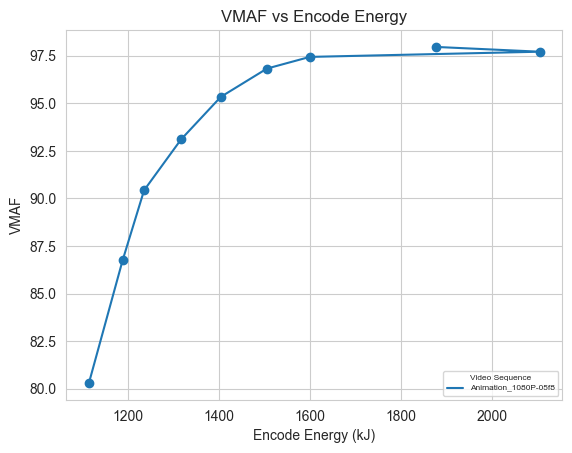

Animation_1080P-3d67
target_encode_energy: [502.2812233386245, 608.1426132007299, 578.3207430882352, 379.256304619469, 399.34944568224296, 341.57246923404256, 330.95130397872333, 322.3716561684211, 312.42729635483863]
VMAF: [99.491664, 99.47137, 99.435378, 99.367448, 99.246377, 99.046355, 98.658382, 96.680756, 85.639336]


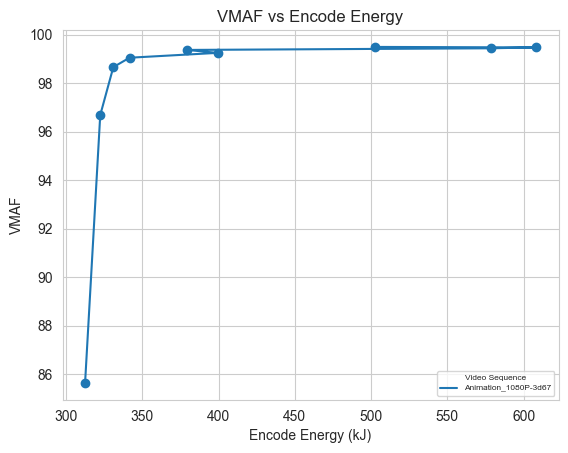

Animation_1080P-646f
target_encode_energy: [1000.6144575635276, 849.5462547129185, 806.4780634009047, 974.6261223542716, 673.953231928934, 708.3190935196078, 629.2207911428571, 619.1546814545455, 611.1781629629629]
VMAF: [93.053408, 92.641734, 92.413355, 91.791661, 91.166537, 90.45969, 89.464155, 87.180074, 80.859253]


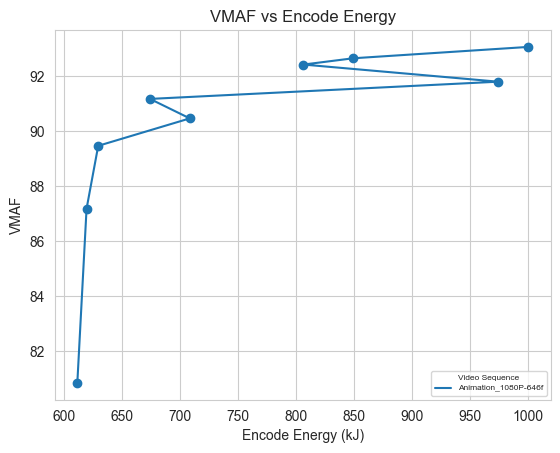

TelevisionClip_1080P-3d83
target_encode_energy: [1446.2455970526314, 670.345945053498, 594.7940747168141, 575.1264306481481, 577.448266450917, 503.9632812820513, 464.5766001649485, 469.9548040322581, 469.44935053012057]
VMAF: [96.037167, 93.241658, 90.351996, 86.328196, 80.003148, 72.982115, 65.484111, 57.678021, 48.088323]


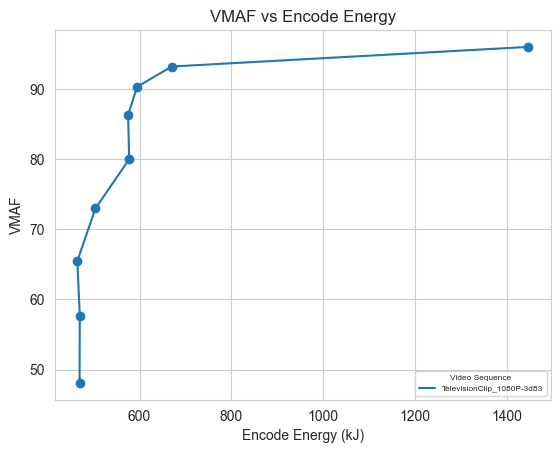

TelevisionClip_1080P-5278
target_encode_energy: [2560.0009562, 1920.4227044833704, 1863.355015836735, 1795.0044867156623, 1711.4446216386768, 1576.2200752338028, 1476.0199990634444, 1391.43794536858, 1316.3144232]
VMAF: [99.322307, 98.851784, 98.240371, 97.091087, 94.946864, 92.023822, 88.850751, 85.688205, 80.527224]


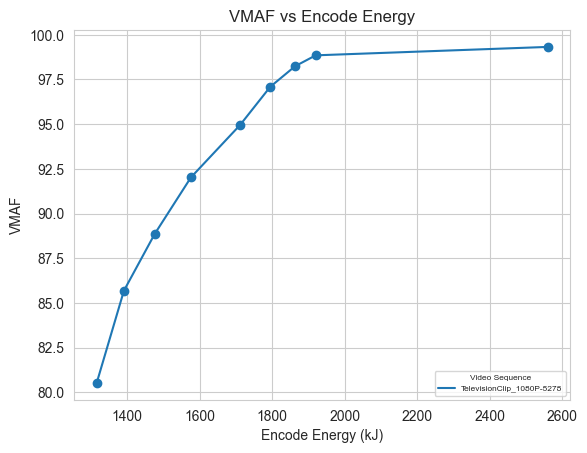

TelevisionClip_1080P-68c6
target_encode_energy: [2538.920060664151, 1269.8167341913042, 1216.6210419116107, 1813.0631176099944, 1030.9659746137338, 940.0119501452511, 854.4424158947368, 807.2422486227546, 790.425457894737]
VMAF: [99.058572, 98.301578, 97.358284, 95.518372, 91.946924, 86.849308, 80.843522, 74.52387, 64.767544]


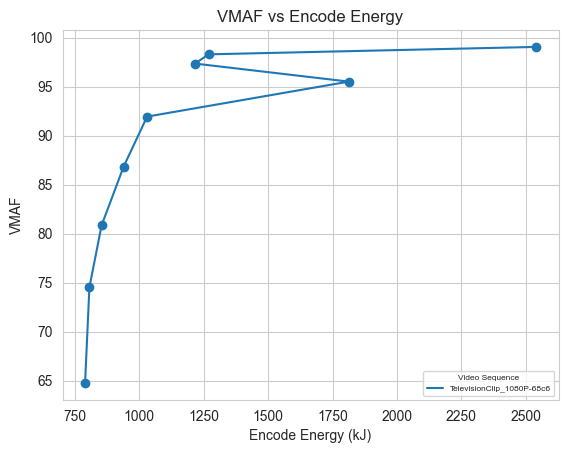

In [576]:
# per video sequence
# fig_op == 'vmaf_encode'
for i in range(len(vid_uniques)):
    metrics_sort = metrics[metrics['vid'] == vid_uniques[i]]
    print(vid_uniques[i])

    x = metrics_sort['target_encode_energy'].tolist()
    print('target_encode_energy:', x)
    y = metrics_sort['VMAF'].tolist()
    print('VMAF:', y)

    plt.plot(x, y, label=vid_uniques[i])
    plt.scatter(x, y)
    plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
    plt.xlabel('Encode Energy (kJ)')
    plt.ylabel('VMAF')
    plt.title('VMAF vs Encode Energy')
    plt.show()

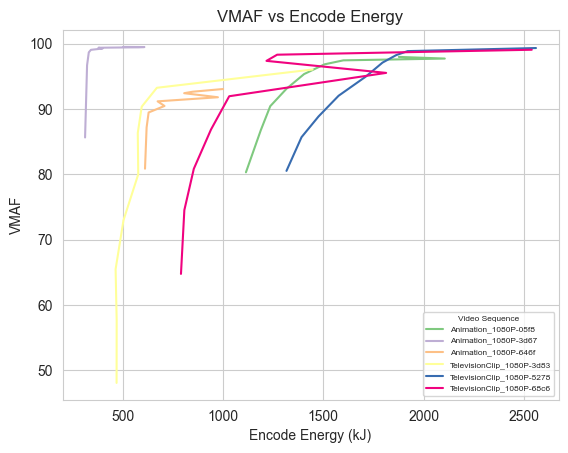

In [577]:
fig_op = 'vmaf_encode'
fig = sns.lineplot(data=metrics, x="target_encode_energy", y="VMAF", hue='vid', palette="Accent", sort=False)
plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
plt.xlabel('Encode Energy (kJ)')
plt.ylabel('VMAF')
plt.title('VMAF vs Encode Energy')
line_fig = fig.get_figure()

Animation_1080P-05f8
target_encode_energy: [1876.455536220208, 2105.410618296034, 1599.8261170889489, 1505.5408941692772, 1404.0909539297809, 1316.726346355987, 1235.4579774394465, 1188.1867961672729, 1114.2859490155645]
PSNR: [45.994384, 44.159637, 42.780976, 40.996289, 39.222075, 37.663094, 36.15991, 34.569354, 32.567567]


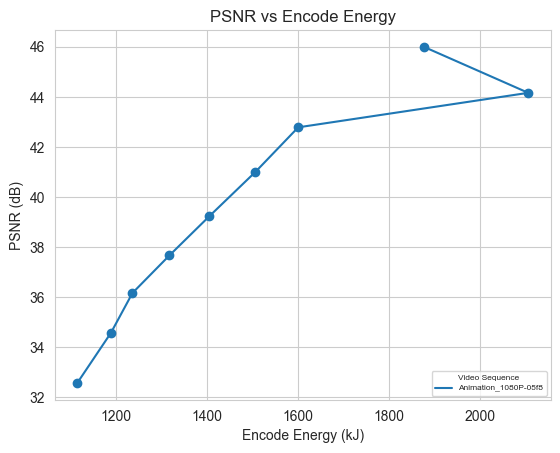

Animation_1080P-3d67
target_encode_energy: [502.2812233386245, 608.1426132007299, 578.3207430882352, 379.256304619469, 399.34944568224296, 341.57246923404256, 330.95130397872333, 322.3716561684211, 312.42729635483863]
PSNR: [45.160744, 42.887876, 41.02101, 38.449747, 35.571603, 32.61945, 29.652771, 26.91987, 23.79294]


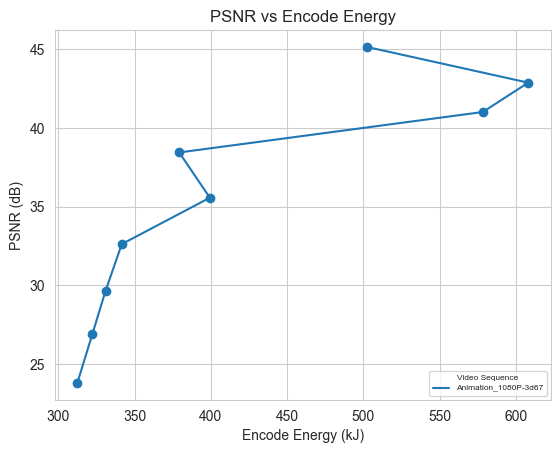

Animation_1080P-646f
target_encode_energy: [1000.6144575635276, 849.5462547129185, 806.4780634009047, 974.6261223542716, 673.953231928934, 708.3190935196078, 629.2207911428571, 619.1546814545455, 611.1781629629629]
PSNR: [45.367046, 44.93304, 44.551208, 43.888326, 43.103484, 42.338354, 41.489579, 40.157771, 37.627842]


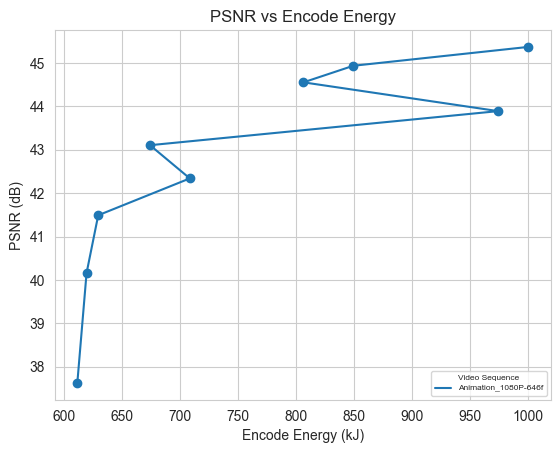

TelevisionClip_1080P-3d83
target_encode_energy: [1446.2455970526314, 670.345945053498, 594.7940747168141, 575.1264306481481, 577.448266450917, 503.9632812820513, 464.5766001649485, 469.9548040322581, 469.44935053012057]
PSNR: [48.022055, 47.097017, 46.362842, 45.574245, 44.630709, 43.643073, 42.646014, 41.659169, 40.25729]


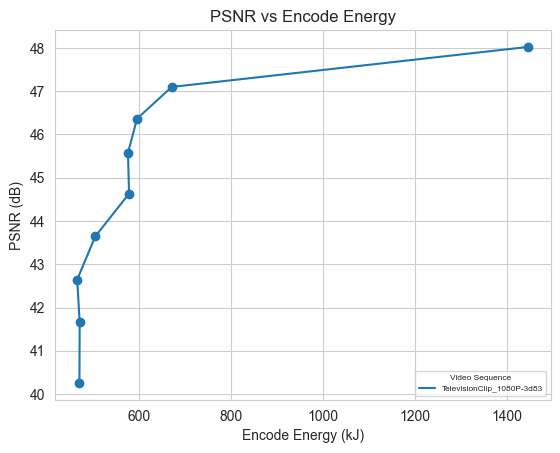

TelevisionClip_1080P-5278
target_encode_energy: [2560.0009562, 1920.4227044833704, 1863.355015836735, 1795.0044867156623, 1711.4446216386768, 1576.2200752338028, 1476.0199990634444, 1391.43794536858, 1316.3144232]
PSNR: [47.241419, 45.318397, 43.900432, 42.072689, 39.899117, 37.953737, 36.459119, 35.377589, 33.969787]


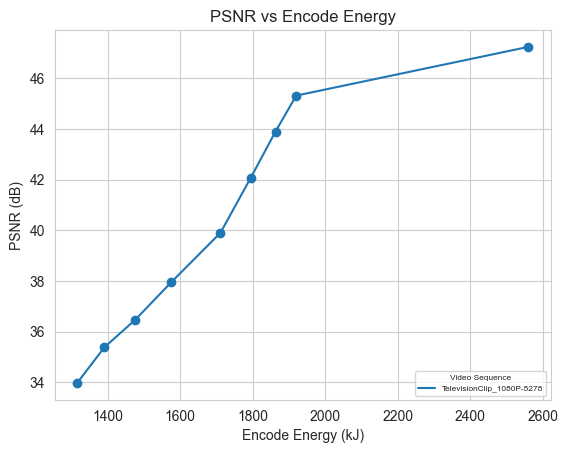

TelevisionClip_1080P-68c6
target_encode_energy: [2538.920060664151, 1269.8167341913042, 1216.6210419116107, 1813.0631176099944, 1030.9659746137338, 940.0119501452511, 854.4424158947368, 807.2422486227546, 790.425457894737]
PSNR: [44.546939, 42.488953, 40.776779, 38.388097, 35.762318, 33.2592, 31.516649, 30.434049, 29.213523]


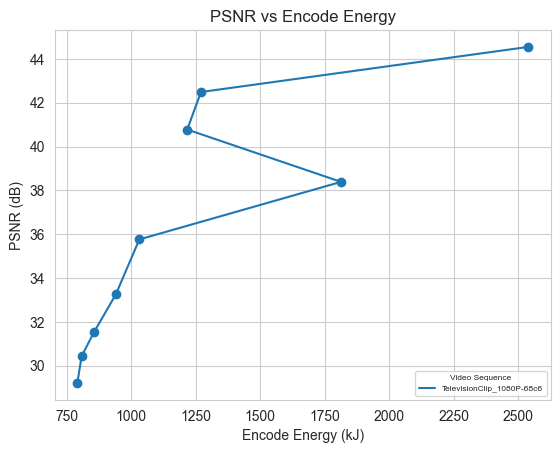

In [578]:
# per video sequence
# fig_op == 'psnr_encode'
for i in range(len(vid_uniques)):
    metrics_sort = metrics[metrics['vid'] == vid_uniques[i]]
    print(vid_uniques[i])

    x = metrics_sort['target_encode_energy'].tolist()
    print('target_encode_energy:', x)
    y = metrics_sort['PSNR'].tolist()
    print('PSNR:', y)

    plt.plot(x, y, label=vid_uniques[i])
    plt.scatter(x, y)
    plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
    plt.xlabel('Encode Energy (kJ)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Encode Energy')
    plt.show()

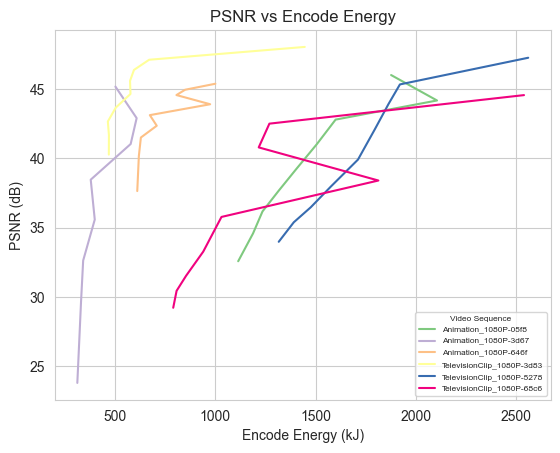

In [579]:
fig_op == 'psnr_encode'
fig = sns.lineplot(data=metrics, x="target_encode_energy", y="PSNR", hue='vid', palette="Accent", sort=False)
plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
plt.xlabel('Encode Energy (kJ)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Encode Energy')
line_fig = fig.get_figure()

Animation_1080P-05f8
bitrate_encoded (kb/s): [27486, 18323, 12981, 7822, 4491, 2759, 1795, 1207, 678]
target_encode_energy: [1876.455536220208, 2105.410618296034, 1599.8261170889489, 1505.5408941692772, 1404.0909539297809, 1316.726346355987, 1235.4579774394465, 1188.1867961672729, 1114.2859490155645]


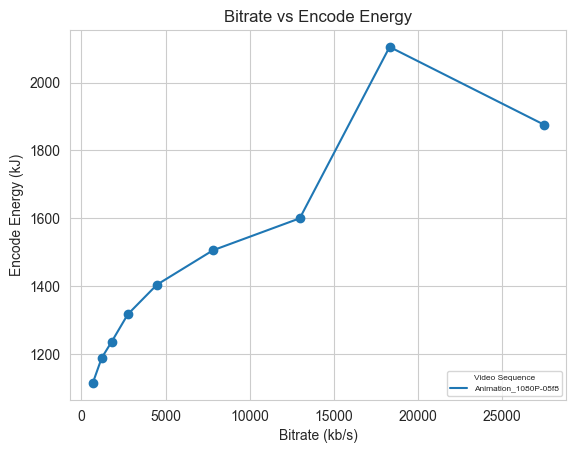

Animation_1080P-3d67
bitrate_encoded (kb/s): [18244, 15185, 13079, 10662, 8324, 6326, 4586, 3236, 1955]
target_encode_energy: [502.2812233386245, 608.1426132007299, 578.3207430882352, 379.256304619469, 399.34944568224296, 341.57246923404256, 330.95130397872333, 322.3716561684211, 312.42729635483863]


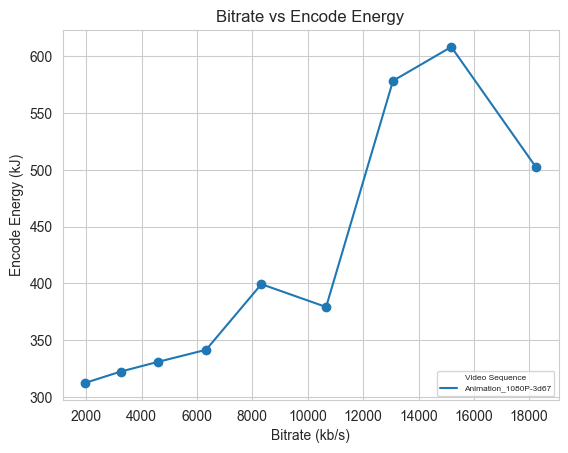

Animation_1080P-646f
bitrate_encoded (kb/s): [4896, 3610, 2823, 1978, 1306, 916, 710, 522, 297]
target_encode_energy: [1000.6144575635276, 849.5462547129185, 806.4780634009047, 974.6261223542716, 673.953231928934, 708.3190935196078, 629.2207911428571, 619.1546814545455, 611.1781629629629]


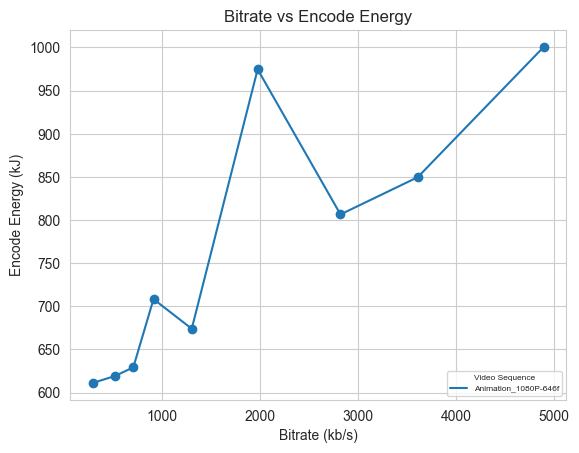

TelevisionClip_1080P-3d83
bitrate_encoded (kb/s): [5261, 3219, 2092, 1229, 662, 380, 234, 152, 96]
target_encode_energy: [1446.2455970526314, 670.345945053498, 594.7940747168141, 575.1264306481481, 577.448266450917, 503.9632812820513, 464.5766001649485, 469.9548040322581, 469.44935053012057]


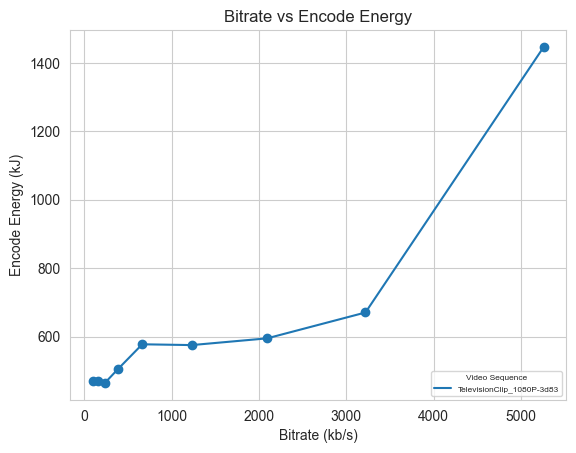

TelevisionClip_1080P-5278
bitrate_encoded (kb/s): [19023, 13732, 10421, 7051, 4212, 2353, 1333, 811, 449]
target_encode_energy: [2560.0009562, 1920.4227044833704, 1863.355015836735, 1795.0044867156623, 1711.4446216386768, 1576.2200752338028, 1476.0199990634444, 1391.43794536858, 1316.3144232]


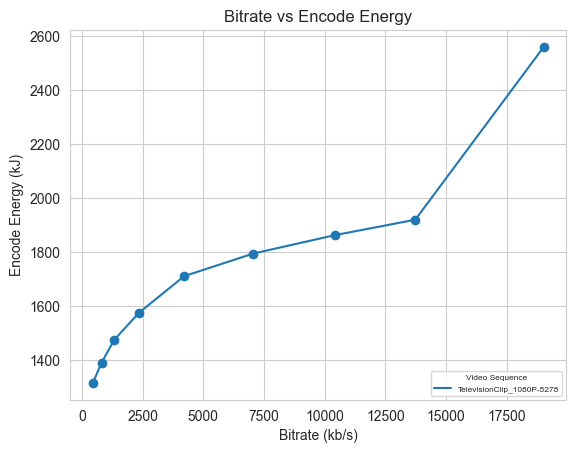

TelevisionClip_1080P-68c6
bitrate_encoded (kb/s): [59432, 46179, 36226, 25111, 14966, 7391, 3541, 1817, 780]
target_encode_energy: [2538.920060664151, 1269.8167341913042, 1216.6210419116107, 1813.0631176099944, 1030.9659746137338, 940.0119501452511, 854.4424158947368, 807.2422486227546, 790.425457894737]


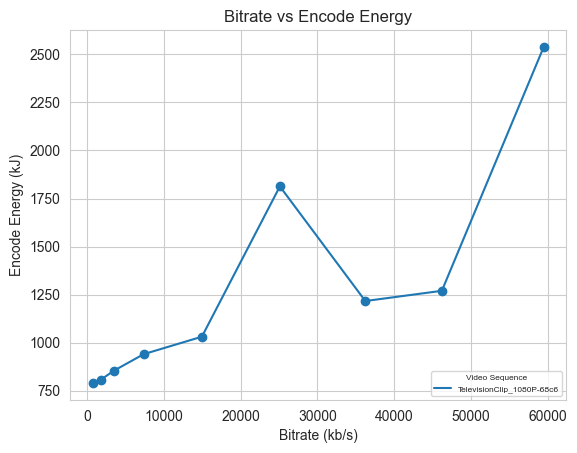

In [580]:
# per video sequence
# fig_op == 'bitrate_encode'
for i in range(len(vid_uniques)):
    metrics_sort = metrics[metrics['vid'] == vid_uniques[i]]
    print(vid_uniques[i])

    x = metrics_sort['bitrate_encoded (kb/s)'].tolist()
    print('bitrate_encoded (kb/s):', x)
    y = metrics_sort['target_encode_energy'].tolist()
    print('target_encode_energy:', y)

    plt.plot(x, y, label=vid_uniques[i])
    plt.scatter(x, y)
    plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
    plt.xlabel('Bitrate (kb/s)')
    plt.ylabel('Encode Energy (kJ)')
    plt.title('Bitrate vs Encode Energy')
    plt.show()

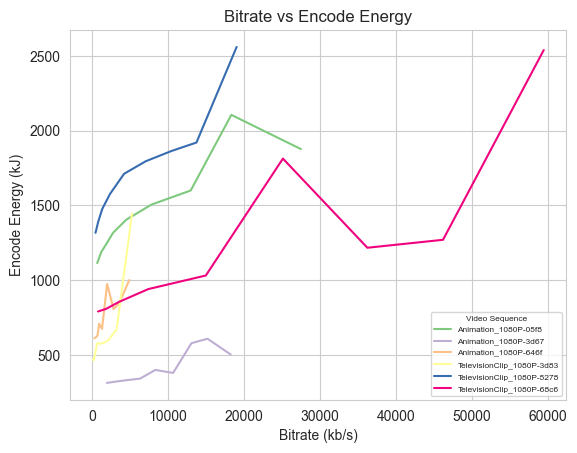

In [581]:
fig_op == 'bitrate_encode'
fig = sns.lineplot(data=metrics, x="bitrate_encoded (kb/s)", y="target_encode_energy", hue='vid', palette="Accent", sort=False)
plt.legend(loc='lower right', title='Video Sequence', fontsize=6, title_fontsize=6)
plt.xlabel('Bitrate (kb/s)')
plt.ylabel('Encode Energy (kJ)')
plt.title('Bitrate vs Encode Energy')
line_fig = fig.get_figure()